## Drug-disease link classification using knowledge graph

This notebook contains scripts to train and evaluate a classifier that predicts whether a drug treats a disease.

- Classifier:
    - GCN based classification
    - Split - No same drug on training and testing

In [ ]:
fro 

In [295]:
import os, re
import pandas as pd 
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


In [32]:
data_dir = "data/"
output_dir = "output/"

In [8]:
os.makedirs(output_dir, exist_ok=True)

In [9]:
os.listdir(input_dir)

['Edges.csv',
 'Embeddings.csv',
 'Ground Truth.csv',
 'Nodes.csv',
 'sampled_kg_gt_dataset.csv']

## Load embedding data and ground truth data

In [90]:
embd_csv = pd.read_csv(os.path.join(data_dir, "Embeddings.csv"), usecols=['id', 'topological_embedding'])
print(f"The embedding file contain {len(embd_csv)} entries")

The embedding file contain 170009 entries


In [92]:
# View first 5 elements
embd_csv.head(5)

,id,topological_embedding
0,UniProtKB:P53805,[-0.09720507 -0.02366368 -0.01756126 -0.096430...
1,UniProtKB:Q4KWH8,[ 0.05282909 0.16689758 0.17749593 0.028352...
2,UniProtKB:Q9UPU7,[-1.98048055e-02 3.08241490e-02 -1.16399840e-...
3,UniProtKB:P35462,[-0.16700847 0.00287975 -0.02125628 -0.196755...
4,UniProtKB:Q9UJY1,[-2.49186769e-01 -2.17781356e-03 -1.74910173e-...


In [93]:
## Read ground truth data 
gt = pd.read_csv(os.path.join(data_dir, "Ground Truth.csv"))
print(f"The ground truth file contain {len(gt)} connections")

The ground truth file contain 28368 connections


In [94]:
# View first 5 rows
gt.head(5)

,Unnamed: 0,source,target,y
0,0,CHEMBL.COMPOUND:CHEMBL30,MONDO:0007186,1
1,1,CHEMBL.COMPOUND:CHEMBL3707202,MONDO:0007186,1
2,2,CHEMBL.COMPOUND:CHEMBL1502,MONDO:0007186,1
3,3,CHEMBL.COMPOUND:CHEMBL480,MONDO:0007186,1
4,4,CHEMBL.COMPOUND:CHEMBL3833310,MONDO:0007186,1


Text(0.5, 1.0, 'Class distribution')

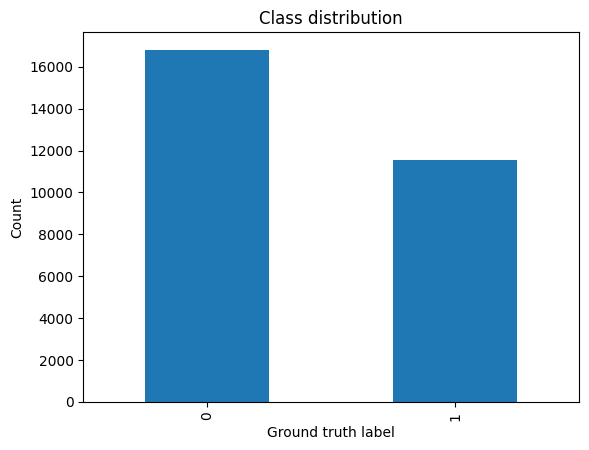

In [99]:
ax = gt.y.value_counts().plot(kind='bar')
ax.set_ylabel("Count")
ax.set_xlabel("Ground truth label")
ax.set_title("Class distribution")

## Check if all nodes in the ground truth are in embedding file

In [95]:
if len(set(embd.id).intersection(gt.source)) == len(set(gt.source)):
    print(f"Pass: All SOURCE nodes in ground truth are in embedding file")
else:
    raise Exception("Fail: Some SOURCE nodes in ground truth file are not in embedding file")

Pass: All SOURCE nodes in ground truth are in embedding file


In [96]:
if len(set(embd.id).intersection(gt.target)) == len(set(gt.target)):
    print(f"Pass: All TARGET nodes in ground truth are in embedding file")
else: 
    raise Exception("Fail: Some TARGET nodes in ground truth file are not in embedding file")

Pass: All TARGET nodes in ground truth are in embedding file


## Extract embedding of nodes with ground

In [57]:
def get_embd_as_list_float(x):
    x = re.sub(r"[\s\n]+", ",", x)
    x = re.sub(r"[\[\]]", "", x).strip(",")

    x_list_float = [float(num) for num in x.split(',')]

    return x_list_float

In [108]:
nodes = list(gt.target.unique())+ list(gt.source.unique())
embd_csv = embd_csv.loc[embd_csv['id'].isin(nodes), :].reset_index(drop=True)
print(f"After filtering there are {len(embd_csv)} entries")

embd_csv["topological_embedding"] = embd_csv["topological_embedding"].map(get_embd_as_list_float)

After filtering there are 3785 entries


In [109]:
torch.tensor(embd_csv["topological_embedding"].tolist()).shape

torch.Size([3785, 128])

In [110]:
embd_csv.head(10)

,index,id,topological_embedding
0,1348,MONDO:0001830,"[-0.1513578, 0.0652519986, -0.180281922, 0.111..."
1,2125,MONDO:0008608,"[-0.325600624, 0.0760474876, 0.299130887, -0.2..."
2,6353,CHEMBL.COMPOUND:CHEMBL413196,"[0.17466034, -0.20936072, -0.28108853, -0.1967..."
3,9748,MONDO:0043519,"[-0.12315283, -0.246667936, 0.101165146, -0.11..."
4,9750,MESH:D003560,"[-0.12088633, 0.04177426, 0.03665263, 0.039064..."
5,9754,MESH:D005402,"[0.09524457, -0.01976925, 0.28921902, 0.073332..."
6,9759,MONDO:0017767,"[0.16381717, -0.35407862, -0.10864656, -0.3503..."
7,9764,MONDO:0005185,"[0.2658501, -0.3406598, -0.05656455, -0.340890..."
8,9768,UMLS:C1611640,"[-0.0878803506, -0.0602803081, -0.0626331642, ..."
9,9785,UMLS:C0003232,"[-0.302921116, 0.0135746887, 0.165542558, 0.44..."


In [114]:
embd_csv.loc[embd_csv['id'] == 'CHEMBL.COMPOUND:CHEMBL413196', :].index[0]

2

In [240]:
 def plot_nodes_degree_distribution(data, comment=None):

    data.reset_index(drop=True, inplace=True)
    ax = data["source"].value_counts().plot(kind='bar')
    ax.set_xticks([])
    ax.set_ylabel("Degree")
    ax.set_xlabel("Source node")
    ax.set_title(f"{comment + ':' if comment else ''} Dribution of degree of source nodes")
    plt.show()
    
    ax1 = data["target"].value_counts().plot(kind='bar')
    ax1.set_xticks([])
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Target node")
    ax1.set_title(f"{comment + ':' if comment else ''} Dribution of degree of target nodes")
    plt.show()

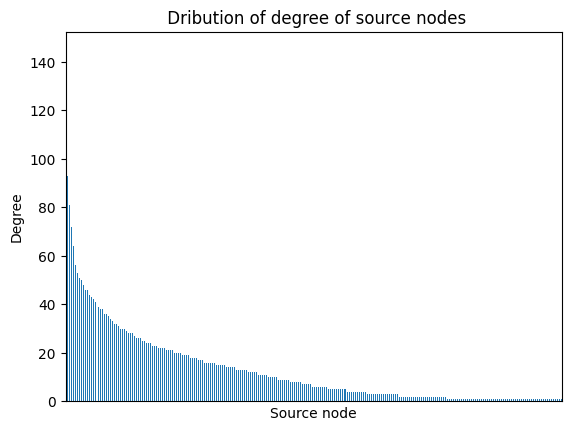

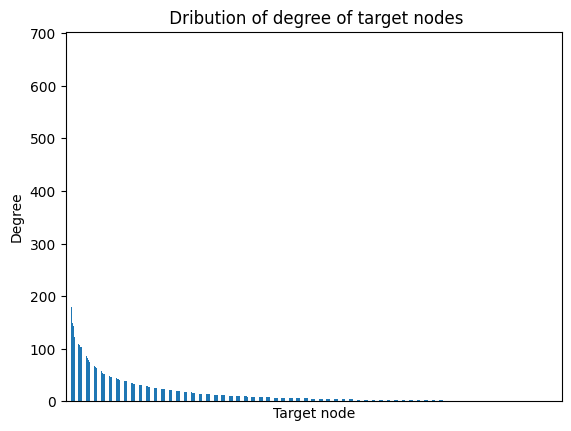

In [241]:
plot_nodes_degree_distribution(gt)

In [328]:
def stratified_train_test_split(df, group_col, target_col, test_size=0.4, random_state=10000000):
    
    grouped = df.groupby(group_col)
    
    # Create a unique identifier for each group
    groups = list(grouped.groups.keys())
    
    # Map the target column to each group (e.g., by taking the majority target in each group)
    group_targets = grouped[target_col].apply(lambda x: x.mode()[0])  # Use mode for stratification
    
    # Perform stratified splitting based on group targets
    train_groups, test_groups = train_test_split(
        groups,
        test_size=test_size,
        stratify=group_targets,random_state=random_state
    )
    
    # Create training and testing datasets by filtering the original DataFrame
    train_df = df[df[group_col].isin(train_groups)].reset_index(drop=True)
    test_df = df[df[group_col].isin(test_groups)].reset_index(drop=True)

    ## check if there are the same disease in both training and test 
    assert len(set(train_df.target).intersection(test_df.target)) == 0, "there is overlap"
    
    # Output the result
    print("Training Set Size:", len(train_df))
    print("Test Set Size:", len(test_df))

    return train_df, test_df


In [243]:
train_val_graph, test_graph = stratified_train_test_split(gt, "target", "y", test_size=0.2)
train_graph, val_graph = stratified_train_test_split(train_val_graph, "target", "y", test_size=0.2)

Training Set Size: 22197
Test Set Size: 6171
Training Set Size: 17853
Test Set Size: 4344


In [244]:
test_graph.source.value_counts().min()

1

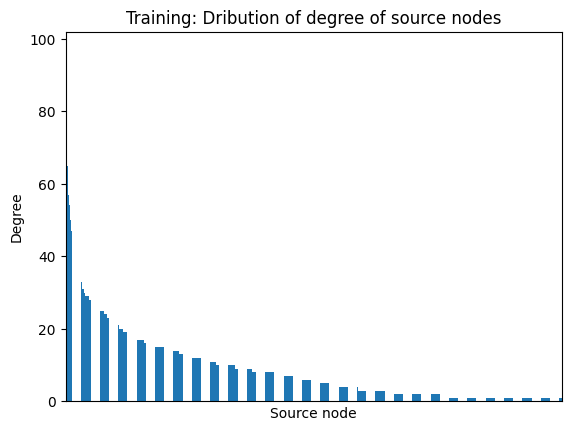

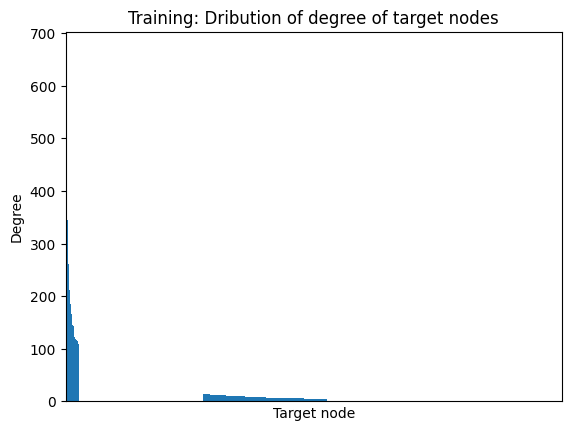

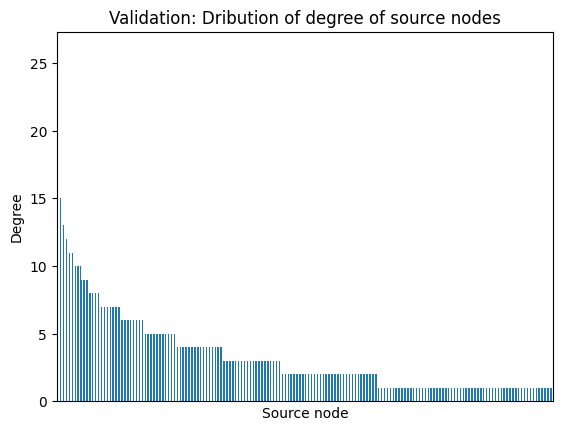

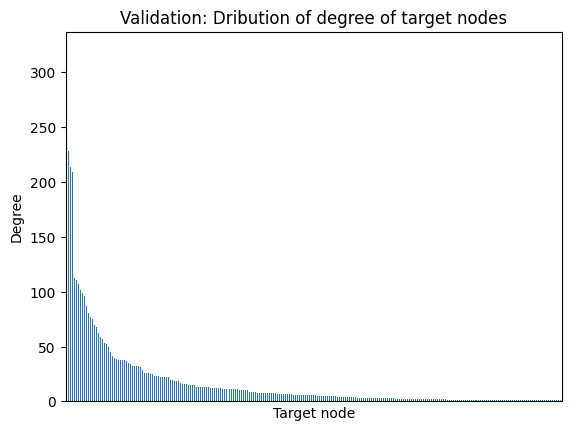

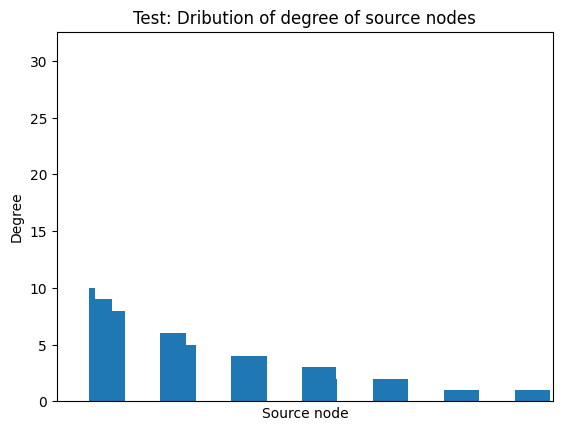

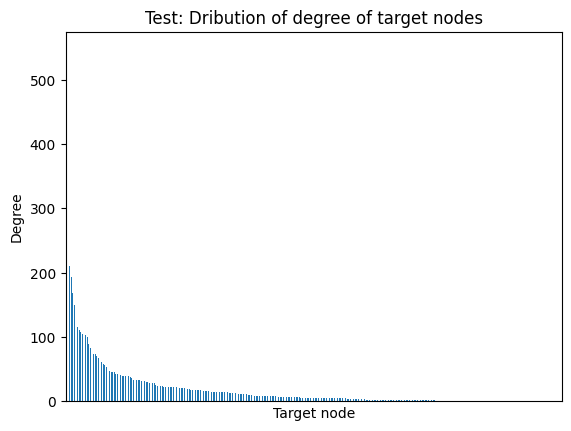

In [245]:
plot_nodes_degree_distribution(train_graph, comment='Training')
plot_nodes_degree_distribution(val_graph, comment='Validation')
plot_nodes_degree_distribution(test_graph, comment='Test')

## Create geometric dataset from knowledge graph

In [227]:
def create_geo_data_v0(input_kg):
    """
    Create a node features and edge index from knowledge graph
    """

    target_nodes = sorted(list(set(input_kg.target)))
    source_nodes = sorted(list(set(input_kg.source)))

    # number of nodes
    n_nodes = len(target_nodes + source_nodes)
    # embeding dimension 
    emb_dim = len(input_kg.target_embedding[0])

    # placeholder for node features
    nodes_feature = torch.zeros(n_nodes, emb_dim, dtype=torch.float32)

    # lets put source nodes followed by target nodes in the node feature matrix
    # create a node to index mapping dictionaries for both 
    n = len(source_nodes)
    
    # update node feature matrix for source nodes
    for idx, node_name in zip(range(len(source_nodes))):
        nodes_feature[idx, :] = torch.tensor(input_kg.loc[input_kg['source'] == node_name, ["source_embedding"]].to_numpy()[0])

    # update node feature matrix for target nodes
    for idx, node_name in zip(range(len(target_nodes))):
        nodes_feature[n+idx, :] = torch.tensor(input_kg.loc[input_kg['target'] == node_name, ["target_embedding"]].to_numpy()[0])
        
    # palceholder for edge index
    edge_index = torch.zeros(2, len(input_kg), dtype=torch.float32)


def create_graph_data(embedding_csv, edge_csv):

    # Extract embedding for nodes within the edge csv file
    nodes_list = edge_csv.target.unique().tolist() + edge_csv.source.unique().tolist()
    embedding_csv_selected = embedding_csv.loc[embedding_csv['id'].isin(nodes_list), :].reset_index(drop=True)
    node_features = torch.tensor(embedding_csv_selected['topological_embedding'].tolist(), dtype=torch.float32)
    # print(f"number of nodes in the graph:{embedding_csv_selected.shape[0]}")

    # create edge index
    edge_csv.reset_index(drop=True, inplace=True)
    n_edges = len(edge_csv)
    # edges are directional: from source (drug) to target (disease)
    edge_index = torch.zeros(2, n_edges, dtype=torch.int32)
    # print(f"number of edges in the data:{edge_index.shape[1]}")
    edge_label = torch.zeros(n_edges, dtype=torch.long)
    for idx, row in edge_csv.iterrows():
        edge_index[0, idx] = embedding_csv_selected.loc[embedding_csv_selected['id'] == row['source'], :].index[0]
        edge_index[1, idx] = embedding_csv_selected.loc[embedding_csv_selected['id'] == row['target'], :].index[0]

        edge_label[idx] = row['y']

    # data = Data(node_features, edge_index, edge_labela
    data = Data(x=node_features, edge_index=edge_index, y=edge_label)

    print(f"Node features/embedding dimension:{data.x.shape}")
    print(f"Edge index dimension:{data.edge_index.shape}")
    print(f"Edge labels dimension:{data.y.shape}")

    return data
    

In [253]:
print("Create TRAINING graph data...")
train_graph_data = create_graph_data(embd_csv, train_graph)

print("Create VALIDATION graph data..")
val_graph_data = create_graph_data(embd_csv, val_graph)

print("Create TEST graph data...")
test_graph_data = create_graph_data(embd_csv, test_graph)

Create TRAINING graph data...
Node features/embedding dimension:torch.Size([3005, 128])
Edge index dimension:torch.Size([2, 17853])
Edge labels dimension:torch.Size([17853])
Create VALIDATION graph data..
Node features/embedding dimension:torch.Size([1567, 128])
Edge index dimension:torch.Size([2, 4344])
Edge labels dimension:torch.Size([4344])
Create TEST graph data...
Node features/embedding dimension:torch.Size([1806, 128])
Edge index dimension:torch.Size([2, 6171])
Edge labels dimension:torch.Size([6171])


In [318]:
class EdgeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(EdgeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.edge_mlp = torch.nn.Linear(2 * hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Node feature update
        x = nn.relu(self.conv1(x, edge_index))
        x = nn.relu(self.conv2(x, edge_index))
        
        # Edge classification
        source, target = edge_index
        edge_features = torch.cat([x[source], x[target]], dim=1)  # Combine node pairs
        out = self.edge_mlp(edge_features)
        return out

# Example usage
featured_dim = data.x.shape[1]
num_class = 2
epochs = 500
early_stop = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [319]:
model = EdgeClassifier(in_channels=featured_dim, hidden_channels=32, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criteria = nn.CrossEntropyLoss()

In [321]:
def train(train_data, val_data, optim, criteria, output_dir, epochs=100):
    # create output folder it does not exist 
    os.makedirs(output_dir, exist_ok=True)

    best_val_loss = float("inf")
    patience = 0
    val_loss_hist = []
    train_loss_hist = []

    for epoch in tqdm(range(epochs), desc="Training/validation", total=epochs):

        # train model
        model.train()
        optim.zero_grad()
        out = model(train_data.x.to(device), train_data.edge_index.to(device))  # Predict edge classes
        train_loss = criteria(out, train_data.y.to(device))
        train_loss.backward()
        optim.step()
        train_loss_hist.append(train_loss.item())

        # validation
        model.eval()
        with torch.no_grad():
            out = model(val_data.x.to(device), val_data.edge_index.to(device))
            val_loss = criteria(out, val_data.y.to(device))
            val_loss_hist.append(val_loss.item())

        # print loss every 5 epoch
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}: {train_loss:.4f}, {val_loss:.4f}")

        # check early stopping
        if (best_val_loss - val_loss.item()) > 1e-3:
            
            # print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
            best_val_loss = val_loss.item()
            torch.save(model.state_dict(), os.path.join(output_dir, "best_model.pt"))
            patience = 0
        else:
            patience += 1
            if patience > early_stop:
                # print(f"Early stop reached at epoch {epoch} since validation loss did't improve for {patience} epochs")
                break

    return train_loss_hist, val_loss_hist       

In [322]:
train_loss_hist, val_loss_hist = train(train_graph_data, val_graph_data, optimizer, criteria, output_dir, epochs=epochs)

Training/validation:   1%|█▏                                                                                                                                                    | 4/500 [00:00<00:14, 33.39it/s]

Epoch 0/500: 0.6293, 0.6424


Training/validation:   7%|██████████▋                                                                                                                                         | 36/500 [00:00<00:04, 100.70it/s]

Epoch 10/500: 0.6109, 0.6292
Epoch 20/500: 0.6039, 0.6246
Epoch 30/500: 0.6008, 0.6226
Epoch 40/500: 0.5985, 0.6204


Training/validation:  14%|████████████████████▋                                                                                                                               | 70/500 [00:00<00:03, 136.46it/s]

Epoch 50/500: 0.5962, 0.6176
Epoch 60/500: 0.5942, 0.6156
Epoch 70/500: 0.5923, 0.6134
Epoch 80/500: 0.5904, 0.6115


Training/validation:  23%|█████████████████████████████████▊                                                                                                                 | 115/500 [00:00<00:02, 140.42it/s]

Epoch 90/500: 0.5885, 0.6096
Epoch 100/500: 0.5865, 0.6077
Epoch 110/500: 0.5845, 0.6056
Epoch 120/500: 0.5824, 0.6035


Training/validation:  29%|██████████████████████████████████████████▉                                                                                                        | 146/500 [00:01<00:02, 145.37it/s]

Epoch 130/500: 0.5801, 0.6011
Epoch 140/500: 0.5777, 0.5987
Epoch 150/500: 0.5750, 0.5961


Training/validation:  35%|███████████████████████████████████████████████████▋                                                                                               | 176/500 [00:01<00:02, 136.65it/s]

Epoch 160/500: 0.5727, 0.5935
Epoch 170/500: 0.5703, 0.5912
Epoch 180/500: 0.5679, 0.5891


Training/validation:  41%|████████████████████████████████████████████████████████████▌                                                                                      | 206/500 [00:01<00:02, 131.05it/s]

Epoch 190/500: 0.5654, 0.5866
Epoch 200/500: 0.5628, 0.5841
Epoch 210/500: 0.5604, 0.5817


Training/validation:  50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 250/500 [00:01<00:01, 137.34it/s]

Epoch 220/500: 0.5579, 0.5794
Epoch 230/500: 0.5555, 0.5769
Epoch 240/500: 0.5531, 0.5746


Training/validation:  53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 265/500 [00:02<00:01, 138.93it/s]

Epoch 250/500: 0.5506, 0.5723
Epoch 260/500: 0.5481, 0.5700
Epoch 270/500: 0.5457, 0.5678
Epoch 280/500: 0.5432, 0.5656


Training/validation:  63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 314/500 [00:02<00:01, 141.81it/s]

Epoch 290/500: 0.5407, 0.5634
Epoch 300/500: 0.5382, 0.5612
Epoch 310/500: 0.5355, 0.5586


Training/validation:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 346/500 [00:02<00:01, 144.81it/s]

Epoch 320/500: 0.5326, 0.5563
Epoch 330/500: 0.5299, 0.5541
Epoch 340/500: 0.5273, 0.5518
Epoch 350/500: 0.5247, 0.5497


Training/validation:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 377/500 [00:02<00:00, 148.03it/s]

Epoch 360/500: 0.5222, 0.5477
Epoch 370/500: 0.5198, 0.5458
Epoch 380/500: 0.5174, 0.5439


Training/validation:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 409/500 [00:03<00:00, 150.65it/s]

Epoch 390/500: 0.5150, 0.5422
Epoch 400/500: 0.5126, 0.5403
Epoch 410/500: 0.5102, 0.5385
Epoch 420/500: 0.5077, 0.5366


Training/validation:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 443/500 [00:03<00:00, 152.70it/s]

Epoch 430/500: 0.5050, 0.5344
Epoch 440/500: 0.5016, 0.5309
Epoch 450/500: 0.4990, 0.5291


Training/validation:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 478/500 [00:03<00:00, 159.66it/s]

Epoch 460/500: 0.4964, 0.5273
Epoch 470/500: 0.4938, 0.5255
Epoch 480/500: 0.4912, 0.5237
Epoch 490/500: 0.4887, 0.5219


Training/validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 137.93it/s]


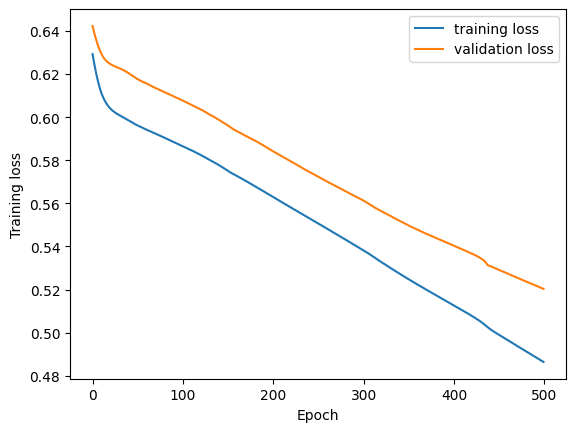

In [323]:
plt.plot(train_loss_hist, label='training loss')
plt.plot(val_loss_hist, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel("Training loss")
plt.legend()

In [325]:
def test_model(model, test_data):
    # Test Loop with Confusion Matrix and Classification Report
    model.eval()
    targets = test_data.y
    print(targets.shape)
    
    with torch.no_grad():
        outputs = model(test_data.x.to(device), test_data.edge_index.to(device))
        _, preds = torch.max(outputs.cpu(), 1)
    print(preds.shape)
    # Confusion Matrix and Metrics
    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    # Precision, Recall, F1 Score
    # precision = precision_score(targets, preds)
    # recall = recall_score(targets, preds)
    # f1_score_ = f1_score(targets, preds)
    # print(f"Classification evaluation metrics:\nprecision: {precision:.2f}\nrecall: {recall:.2f} and\nf1_score: {f1_score_:.2f}")
    report = classification_report(targets, preds, target_names=["Class 0", "Class 1"])
    print("Classification Report:\n", report)
    # return precision, recall, f1_score_

torch.Size([6171])
torch.Size([6171])


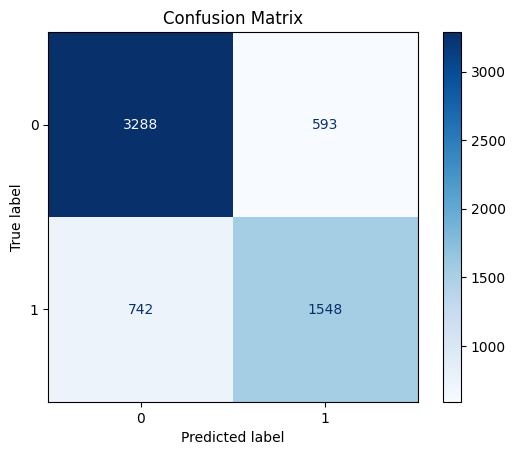

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.82      0.85      0.83      3881
     Class 1       0.72      0.68      0.70      2290

    accuracy                           0.78      6171
   macro avg       0.77      0.76      0.76      6171
weighted avg       0.78      0.78      0.78      6171



In [327]:
 test_model(model, test_graph_data)